# peewee Official Tutorial

## Database

Recommended pragma parameters and values<br>
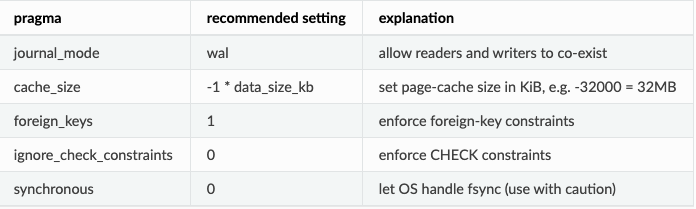

In [3]:

from peewee import SqliteDatabase

db = SqliteDatabase(database='./app.db', pragmas={'journal_mode': 'wal', 
                                                        'cache_size': -1024 * 64,
                                                        'foreigh_keys': 1,
                                                        'ignore_check_constraints': 0,
                                                        'synchronous': 0})

db.connect()


True

## User-defined Functions

SQLite can be extended with user-defined Python code. The SqliteDatabase class supports three types of user-defined extensions:<br><br>

Functions - which take any number of parameters and return a single value.<br>
Aggregates - which aggregate parameters from multiple rows and return a single value.<br>
Collations - which describe how to sort some value.

In [11]:

from collections import Counter

@db.func
def table_count_alphabetical():
    """Gets counter dictionary for number of tables starting with each letter"""
    cursor = db.execute_sql(sql="SELECT name FROM sqlite_master WHERE type='table'")
    first_letter = [name[0] for name in cursor]
    return Counter(first_letter)


## Set Locking Mode for Transaction

SQLite transactions can be opened in three different modes:<br><br>

Deferred (default) - only acquires lock when a read or write is performed. The first read creates a shared lock and the first write creates a reserved lock. Because the acquisition of the lock is deferred until actually needed, it is possible that another thread or process could create a separate transaction and write to the database after the BEGIN on the current thread has executed.<br><br>

Immediate - a reserved lock is acquired immediately. In this mode, no other database may write to the database or open an immediate or exclusive transaction. Other processes can continue to read from the database, however.<br><br>

Exclusive - opens an exclusive lock which prevents all (except for read uncommitted) connections from accessing the database until the transaction is complete.

In [17]:

from peewee import fn

with db.atomic('EXCLUSIVE'):
    counter = fn.table_count_alphabetical()

@db.atomic('IMMEDIATE')
def do_something_else():
    # This function is wrapped in an "IMMEDIATE" transaction.
    pass


## APSW, an Advanced SQLite Driver

Peewee also comes with an alternate SQLite database that uses apsw, an advanced sqlite driver, an advanced Python SQLite driver. More information on APSW can be obtained on the APSW project website. APSW provides special features like:<br><br>

Virtual tables, virtual file-systems, Blob I/O, backups and file control.<br>
Connections can be shared across threads without any additional locking.<br>
Transactions are managed explicitly by your code.<br>
Unicode is handled correctly.<br>
APSW is faster that the standard library sqlite3 module.<br>
Exposes pretty much the entire SQLite C API to your Python app.

In [26]:

from playhouse.apsw_ext import APSWDatabase
apsw_db = APSWDatabase(database='./my_app.db')


## Connecting Using a Database URL

The playhouse module Database URL provides a helper connect() function that accepts a database URL and returns a Database instance.

In [27]:

import os
from peewee import Model
from playhouse.db_url import connect

# Connect to the database URL defined in the environment, falling
# back to a local Sqlite database if no database URL is specified.
db = connect(os.environ.get('DATABASE') or 'sqlite:///default.db')

class BaseModel(Model):
    class Meta:
        database = db


Example Database URLs

sqlite:///my_database.db will create a SqliteDatabase instance for the file my_database.db in the current directory.<br><br>

sqlite:///:memory: will create an in-memory SqliteDatabase instance.

## Run-time Database Configuration

Sometimes the database connection settings are not known until run-time, when these values may be loaded from a configuration file or the environment. In these cases, you can defer the initialization of the database by specifying None as the database_name.

In [29]:

from peewee import Model, SqliteDatabase
db = SqliteDatabase(database=None)

class SomeModel(Model):
    class Meta:
        database = db
